In [1]:
import torch
import triton
import triton.language as tl

/mnt/workspace/mdy/miniforge/envs/mdy/lib/python3.10/site-packages/_distutils_hack/__init__.py:53: UserWarning: Reliance on distutils from stdlib is deprecated. Users must rely on setuptools to provide the distutils module. Avoid importing distutils or import setuptools first, and avoid setting SETUPTOOLS_USE_DISTUTILS=stdlib. Register concerns at https://github.com/pypa/setuptools/issues/new?template=distutils-deprecation.yml
  warnings.warn(


In [2]:

def get_autotune_config_offical():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64, 'GROUP_SIZE_M': 8}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32, 'GROUP_SIZE_M': 8}, num_stages=5,
                      num_warps=2),
    ]


def get_autotune_config_my():
    return [
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 64}, num_stages=3,
                      num_warps=8),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 256, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 128, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 128, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=4,
                      num_warps=4),
        triton.Config({'BLOCK_SIZE_M': 64, 'BLOCK_SIZE_N': 32, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
        triton.Config({'BLOCK_SIZE_M': 32, 'BLOCK_SIZE_N': 64, 'BLOCK_SIZE_K': 32}, num_stages=5,
                      num_warps=2),
    ]

# offical

In [3]:
@triton.autotune(
    configs=get_autotune_config_offical(),
    key=['M', 'N', 'K'],
)
@triton.jit
def offical_matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        GROUP_SIZE_M: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    # -----------------------------------------------------------
    # Map program ids `pid` to the block of C it should compute.
    # This is done in a grouped ordering to promote L2 data reuse.
    # See above `L2 Cache Optimizations` section for details.
    pid = tl.program_id(axis=0)
    num_pid_m = tl.cdiv(M, BLOCK_SIZE_M)
    num_pid_n = tl.cdiv(N, BLOCK_SIZE_N)
    num_pid_in_group = GROUP_SIZE_M * num_pid_n
    group_id = pid // num_pid_in_group
    first_pid_m = group_id * GROUP_SIZE_M
    group_size_m = min(num_pid_m - first_pid_m, GROUP_SIZE_M)
    pid_m = first_pid_m + ((pid % num_pid_in_group) % group_size_m)
    pid_n = (pid % num_pid_in_group) // group_size_m

    # ----------------------------------------------------------
    # Create pointers for the first blocks of A and B.
    # We will advance this pointer as we move in the K direction
    # and accumulate
    # `a_ptrs` is a block of [BLOCK_SIZE_M, BLOCK_SIZE_K] pointers
    # `b_ptrs` is a block of [BLOCK_SIZE_K, BLOCK_SIZE_N] pointers
    # See above `Pointer Arithmetic` section for details
    offs_am = (pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)) % M
    offs_bn = (pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)) % N
    offs_k = tl.arange(0, BLOCK_SIZE_K)
    a_ptrs = a_ptr + (offs_am[:, None] * stride_am + offs_k[None, :] * stride_ak)
    b_ptrs = b_ptr + (offs_k[:, None] * stride_bk + offs_bn[None, :] * stride_bn)

    # -----------------------------------------------------------
    # Iterate to compute a block of the C matrix.
    # We accumulate into a `[BLOCK_SIZE_M, BLOCK_SIZE_N]` block
    # of fp32 values for higher accuracy.
    # `accumulator` will be converted back to fp16 after the loop.
    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_ptrs, mask=offs_k[None, :] < K - k * BLOCK_SIZE_K, other=0.0)
        b = tl.load(b_ptrs, mask=offs_k[:, None] < K - k * BLOCK_SIZE_K, other=0.0)
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_ptrs += BLOCK_SIZE_K * stride_ak
        b_ptrs += BLOCK_SIZE_K * stride_bk
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    # -----------------------------------------------------------
    # Write back the block of the output matrix C with masks.
    offs_cm = pid_m * BLOCK_SIZE_M + tl.arange(0, BLOCK_SIZE_M)
    offs_cn = pid_n * BLOCK_SIZE_N + tl.arange(0, BLOCK_SIZE_N)
    c_ptrs = c_ptr + stride_cm * offs_cm[:, None] + stride_cn * offs_cn[None, :]
    c_mask = (offs_cm[:, None] < M) & (offs_cn[None, :] < N)
    tl.store(c_ptrs, c, mask=c_mask)


# We can fuse `leaky_relu` by providing it as an `ACTIVATION` meta-parameter in `matmul_kernel`.
@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

# %%
# We can now create a convenience wrapper function that only takes two input tensors,
# and (1) checks any shape constraint; (2) allocates the output; (3) launches the above kernel.


def offical_matmul(a, b, activation=""):
    # Check constraints.
    assert a.shape[1] == b.shape[0], "Incompatible dimensions"
    assert a.is_contiguous(), "Matrix A must be contiguous"
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    BLOCK_SIZE_M = min(128, triton.next_power_of_2(M))
    BLOCK_SIZE_N = min(128, triton.next_power_of_2(N))
    BLOCK_SIZE_K = 128
    GROUP_SIZE_M = 8
    num_warps = 8
    num_stages = 2
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    offical_matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        ACTIVATION=activation,  #
    )
    return c
# 输出结果计算顺序示意图，最外层是super_group，GROUP_SIZE_M=2, 每个super_group都是结果的一部分，block的计算顺序和数字一致
# 他说这么做能提高L2缓存的命中率，我也不太懂硬件知识
grid = torch.arange(64).view(4, 8, 2).transpose(-1, -2)
print(grid)

tensor([[[ 0,  2,  4,  6,  8, 10, 12, 14],
         [ 1,  3,  5,  7,  9, 11, 13, 15]],

        [[16, 18, 20, 22, 24, 26, 28, 30],
         [17, 19, 21, 23, 25, 27, 29, 31]],

        [[32, 34, 36, 38, 40, 42, 44, 46],
         [33, 35, 37, 39, 41, 43, 45, 47]],

        [[48, 50, 52, 54, 56, 58, 60, 62],
         [49, 51, 53, 55, 57, 59, 61, 63]]])


In [ ]:
@triton.autotune(
    configs=get_autotune_config_my(),
    key=['M', 'N', 'K'],
)
@triton.jit
def my_matmul_kernel(
        # Pointers to matrices
        a_ptr, b_ptr, c_ptr,
        # Matrix dimensions
        M, N, K,
        # The stride variables represent how much to increase the ptr by when moving by 1
        # element in a particular dimension. E.g. `stride_am` is how much to increase `a_ptr`
        # by to get the element one row down (A has M rows).
        stride_am, stride_ak,  #
        stride_bk, stride_bn,  #
        stride_cm, stride_cn,
        # Meta-parameters
        BLOCK_SIZE_M: tl.constexpr, BLOCK_SIZE_N: tl.constexpr, BLOCK_SIZE_K: tl.constexpr,  #
        ACTIVATION: tl.constexpr  #
):
    """Kernel for computing the matmul C = A x B.
    A has shape (M, K), B has shape (K, N) and C has shape (M, N)
    """
    pid = tl.program_id(axis=0)
    num_block_n = tl.cdiv(N, BLOCK_SIZE_N)
    pid_m = pid // num_block_n
    pid_n = pid % num_block_n
    # a_ptrs += pid_m * stride_am * BLOCK_SIZE_M
    # n_offset = pid_n * stride_bn * BLOCK_SIZE_N

    a_block_ptrs = tl.make_block_ptr(
        base=a_ptr,
        shape=(M, K),
        strides=(stride_am, stride_ak),
        offsets=(pid_m * BLOCK_SIZE_M, 0),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_K),
        order=(1,0)
    )

    b_block_ptrs = tl.make_block_ptr(
        base=b_ptr,
        shape=(K, N),
        strides=(stride_bk, stride_bn),
        offsets=(0, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_K, BLOCK_SIZE_N),
        order=(1,0)
    )

    c_block_ptrs = tl.make_block_ptr(
        base=c_ptr,
        shape=(M, N),
        strides=(stride_cm, stride_cn),
        offsets=(pid_m*BLOCK_SIZE_M, pid_n*BLOCK_SIZE_N),
        block_shape=(BLOCK_SIZE_M, BLOCK_SIZE_N),
        order=(1,0)
    )



    accumulator = tl.zeros((BLOCK_SIZE_M, BLOCK_SIZE_N), dtype=tl.float32)
    for k in range(0, tl.cdiv(K, BLOCK_SIZE_K)):
        # Load the next block of A and B, generate a mask by checking the K dimension.
        # If it is out of bounds, set it to 0.
        a = tl.load(a_block_ptrs, boundary_check=(0,), padding_option='zero')
        b = tl.load(b_block_ptrs) # 理论上b不会溢出，相当于权重w，dim都是2的指数倍或者BLOCK_SIZE的整数倍
        # We accumulate along the K dimension.
        accumulator = tl.dot(a, b, accumulator)
        # Advance the ptrs to the next K block.
        a_block_ptrs = tl.advance(a_block_ptrs, offsets=(0, BLOCK_SIZE_K))
        b_block_ptrs = tl.advance(b_block_ptrs, offsets=(BLOCK_SIZE_K, 0))
    # You can fuse arbitrary activation functions here
    # while the accumulator is still in FP32!
    if ACTIVATION == "leaky_relu":
        accumulator = leaky_relu(accumulator)
    c = accumulator.to(tl.float16)

    tl.store(c_block_ptrs, c) # M是bs * seq_len， 可能会溢出

@triton.jit
def leaky_relu(x):
    return tl.where(x >= 0, x, 0.01 * x)

# 我实现的这个函数没有什么泛化性，只适用于模型训练里的矩阵乘
# 矩阵a的维度m无所谓， 但是b的n和k这两个都要求是2的指数倍，或者32、64、128的倍数
# 因为kernel里直接读取的block（tl.make_block_ptrs），block只能防止一个维度溢出（需要mask， boundary_check），也就是m
def my_matmul(a, b, activation=""):
    # Check constraints.
    input_shape = a.shape
    a = a.view(-1, input_shape[-1])
    M, K = a.shape
    K, N = b.shape
    # Allocates output.
    c = torch.empty((M, N), device=a.device, dtype=torch.float16)
    # 1D launch kernel where each block gets its own program.
    BLOCK_SIZE_M = min(128, triton.next_power_of_2(M))
    BLOCK_SIZE_N = min(128, triton.next_power_of_2(N))
    BLOCK_SIZE_K = 32
    num_warps = 4
    num_stages = 4
    grid = lambda META: (triton.cdiv(M, META['BLOCK_SIZE_M']) * triton.cdiv(N, META['BLOCK_SIZE_N']), )
    my_matmul_kernel[grid](
        a, b, c,  #
        M, N, K,  #
        a.stride(0), a.stride(1),  #
        b.stride(0), b.stride(1),  #
        c.stride(0), c.stride(1),  #
        # BLOCK_SIZE_M, BLOCK_SIZE_N, BLOCK_SIZE_K,
        ACTIVATION=activation,  #
        # num_warps=num_warps, num_stages=num_stages,
    )
    return c.view(*input_shape[:-1],-1)
# 输出结果直接按着顺序算
grid = torch.arange(64).view(8, 8)
print(grid)

tensor([[ 0,  1,  2,  3,  4,  5,  6,  7],
        [ 8,  9, 10, 11, 12, 13, 14, 15],
        [16, 17, 18, 19, 20, 21, 22, 23],
        [24, 25, 26, 27, 28, 29, 30, 31],
        [32, 33, 34, 35, 36, 37, 38, 39],
        [40, 41, 42, 43, 44, 45, 46, 47],
        [48, 49, 50, 51, 52, 53, 54, 55],
        [56, 57, 58, 59, 60, 61, 62, 63]])


In [9]:
m,n,k = 1024, 768*4, 768
dtype = torch.float16
device = 'cuda'
x = torch.randn(m, k).to(device).to(dtype)
f = torch.nn.Linear(k, n).to(device).to(dtype)
w = f.weight.data

In [10]:
y_offical = offical_matmul(x, w.T)
y_my = my_matmul(x, w.T)
torch.allclose(y_offical, y_my)

True

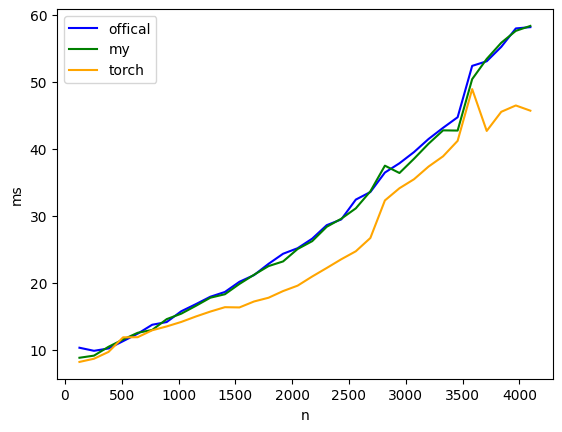

offical vs my:
         n    offical         my      torch
0    128.0  10.287537   8.791327   8.170262
1    256.0   9.828871   9.108339   8.647596
2    384.0  10.179286  10.430696   9.664405
3    512.0  11.270954  11.518819  11.840228
4    640.0  12.379467  12.512821  11.858826
5    768.0  13.717059  12.938651  12.893178
6    896.0  14.123720  14.556606  13.468836
7   1024.0  15.730886  15.371954  14.138402
8   1152.0  16.788930  16.535547  14.946174
9   1280.0  17.898588  17.754558  15.685325
10  1408.0  18.610468  18.269310  16.337715
11  1536.0  20.129237  19.807998  16.301921
12  1664.0  21.123940  21.174286  17.188316
13  1792.0  22.806022  22.470264  17.749645
14  1920.0  24.312327  23.166653  18.743495
15  2048.0  25.140958  25.022341  19.553145
16  2176.0  26.563697  26.188957  20.916132
17  2304.0  28.575750  28.336223  22.189487
18  2432.0  29.437624  29.539080  23.492252
19  2560.0  32.394104  31.088615  24.683008
20  2688.0  33.524174  33.624154  26.664251
21  2816.0  36.43

In [ ]:
torch.cuda.empty_cache()
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['n'],  # argument names to use as an x-axis for the plot
        x_vals=[128 * i for i in range(1, 32+1, 1)],  # different possible values for `x_name`
        line_arg='provider',  # argument name whose value corresponds to a different line in the plot
        line_vals=['offical', 'my', 'torch'],  # possible values for `line_arg``
        line_names=[
            "offical",
            "my",
            'torch',
        ],  # label name for the lines
        styles=[('blue', '-'), ('green', '-'), ('orange', '-')],  # line styles
        ylabel="ms",  # label name for the y-axis
        plot_name="offical vs my",  # name for the plot. Used also as a file name for saving the plot.
        args={'m': 128, 'k': 4096}
    ))
def benchmark(m, n, k, provider):
    device = torch.device('cuda')
    dtype = torch.float16
    # m,n,k = 1024, 768*4, 768
    dtype = torch.float16
    device = 'cuda'
    x = torch.randn(128, n).to(device).to(dtype)
    f = torch.nn.Linear(n, n).to(device).to(dtype)
    w = f.weight.data
    
    stream = torch.cuda.Stream()
    torch.cuda.set_stream(stream)
    if provider == 'offical':
        ms = triton.testing.do_bench(lambda: offical_matmul(x, w.T))

    if provider == 'my':
        ms = triton.testing.do_bench(lambda: my_matmul(x, w.T))

    if provider == 'torch':
        ms = triton.testing.do_bench(lambda: torch.matmul(x, w.T))

    return ms * 1e3
benchmark.run(show_plots=True, print_data=True)
# 其实两者(offical vs my)性能差异不大, 如果想快速实现，表示清楚，直接按顺序计算即可
# dim变大之后，貌似还是torch内置的矩阵乘法更优秀
